# Query Data from other Catalogues
Compare our data with previously published values.

In [1]:
import os
import re
import csv
import glob
import numpy as np

from astroquery.ipac.ned import Ned
from astroquery.simbad import Simbad
from astroquery.casda import Casda
from astroquery.cadc import Cadc
from astroquery.vizier import Vizier
from astropy.coordinates import  SkyCoord
from astropy.table import QTable
import astropy.units as u

import matplotlib.pyplot as plt

## Load Data

In [2]:
imdir = "/rds/user/pmk46/hpc-work/19A-056/final"
qso_catalog = QTable.read('../tables/Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')

ra_list, dec_list = [], []
obsnames = []
qso_names = []

# replace "-" with "_" in obsnames.
for i, imfits in enumerate(glob.glob(os.path.join(imdir, "images/*.fits"))):
    obsname = list(imfits.split("/")[-1][:14])
    obsname[3] = "_"
    obsname = "".join(obsname)
    obsnames.append(obsname)

# format coordinates. Replace ":" with units ("h", "d") and add "s"
for row in qso_catalog:
    if row["QSO-Name"] in obsnames:
        ra = row["RA"]
        dec = row["Dec"]

        ra = ra.replace(":", "h", 1)
        ra = ra.replace(":", "m", 1)
        ra = "".join(list(ra) + ["s",])

        dec = dec.replace(":", "d", 1)
        dec = dec.replace(":", "m", 1)
        dec = "".join(list(dec) + ["s",])

        ra_list.append(ra)
        dec_list.append(dec)
        qso_names.append(row["QSO-Name"])

# convert list to numpy arrays
ra_list = np.array(ra_list)
dec_list = np.array(dec_list)

In [3]:
# load table data
with open('../tables/table2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = np.array([row for row in reader]).T

tablenames = np.array([name.replace("-", "_", 1) for name in data[0]])
z_list, freqs, fluxpeaks, fluxpeaks_err, ul_list, m1450_list, allwise_AB_list, allwise_err_list, spitzer_AB_list, spitzer_AB_err_list, Lsgn, log_L_nu_list, log_L_peak_list, log_L_peak_err_list, log_L_ul_list, log_L4400_list, log_L4400_err_list, R_list, Rerr_list, Rul_list = data[1:].astype(float)

table1 = np.loadtxt("../tables/table1.csv", delimiter=",", dtype=str).T
fluxints = table1[10].astype(float)
mad = table1[2].astype(float)

# list of quasars detected in our survey
det_names = ["QSO_J0100+2802", "QSO_J0231-2850", "QSO_J0818+1722", "QSO_J1034-1425", "QSO_J1427+3312", "QSO_J1429+5447", "QSO_J1558-0724", "QSO_J1602+4228", "QSO_J2318-3113"]


## Query Data

In [4]:
query_dict = dict()

for qso_name, ra, dec in zip(qso_names, ra_list, dec_list):
    coord = SkyCoord(ra=ra,  dec=dec)
    query_dict.update({qso_name : dict()})

    # VLASS
    try:
        vlass = Vizier.query_region(coord, radius=5 * u.arcsec, catalog='J/ApJS/255/30/comp')['J/ApJS/255/30/comp']
        query_dict[qso_name].update({"VLASS": (3, vlass["Ftot"].value, vlass["e_Ftot"].value, False)})
    except:
        pass
    
    # LOTSS DR2
    try:
        lotss = Vizier.query_region(coord, radius=12 * u.arcsec, catalog='J/A+A/659/A1/catalog')['J/A+A/659/A1/catalog']
        query_dict[qso_name].update({"LoTSS": (0.144, lotss["SpeakTot"].value, 0.086, False)})
    except:
        pass
    
    # FIRST
    try:
        first = Vizier.query_region(coord, radius=10 * u.arcsec, catalog='VIII/92/first14')['VIII/92/first14']
        query_dict[qso_name].update({"FIRST": (1.4, first["Fint"].value, 0.15, False)})
    except:
        pass
    
    # query NED
    try:
        name = Ned.query_region(coord, radius=2*u.arcsec)["Object Name"].value[0]
        photometry = Ned.get_table(name, table="photometry")
        idx = photometry["Frequency"] < 1e11
        nr = np.sum(idx)

        if nr > 0:
            print(name, f" {nr} Radio obs.", photometry["Refcode"][idx])
            yerr = []
            uplims = []
            fluxd = []

            for i, err_str in enumerate(photometry["Uncertainty"][idx].value):
                err_val = re.findall("[+-]?((\d+(\.\d*)?)|(\.\d+))([eE][+-]?\d+)?", err_str)
                Aerr = np.where(photometry["Units"][idx] == "milliJy", 1, 1e-3)[i]

                if len(err_val) > 0:
                    err_val = err_val[0]
                else:
                    err_val = [0]
                
                if "<" in err_str:
                    uplims.append(True)
                    fluxd.append(float(err_val[0]) * Aerr)
                    yerr.append(float(err_val[0]) * Aerr * 0.5)
                else:
                    uplims.append(False)
                    fluxd.append(photometry["Flux Density"][idx].value[i] * 1e3)

                    if len(err_val) > 0:
                        yerr.append(float(err_val[0]) * Aerr)
                    else:
                        yerr.append(0)
                
            query_dict[qso_name].update({"NED": (photometry["Frequency"][idx].value * 1e-9, fluxd, yerr, uplims)})
    except:
        pass

WISEA J104845.04+463718.2  1 Radio obs.       Refcode      
-------------------
2004AJ....128..997C
WISEA J114816.61+525150.2  3 Radio obs.       Refcode      
-------------------
2004ApJ...615L..17W
2007ApJ...671L..13R
2004AJ....128..997C
WISEA J131911.26+095051.7  1 Radio obs.       Refcode      
-------------------
2011AJ....142..101W
WISEA J142738.54+331241.7  6 Radio obs.       Refcode      
-------------------
2008A&A...484L..39F
2008A&A...484L..39F
2008AJ....136..344M
2002AJ....123.1784D
2015MNRAS.450.1477C
2016MNRAS.460.2385W
SDSS J150941.78-174926.8  1 Radio obs.       Refcode      
-------------------
2011AJ....142..101W


## Manually add Values from the Literature

In [5]:
query_dict["QSO_J2318-3113"].update({"G23-MIDAS": ([0.154, 0.216], [3.3, 1.8], 0.5 * np.array([3.3, 1.8]), True)})
query_dict["QSO_J2318-3113"].update({"G23-GLASS": ([0.399, 5.5], [0.89, 0.104], [0.15, 0.034], False)})
query_dict["QSO_J2318-3113"].update({"G23-EMU": (0.888, 0.59, 0.07, False)})
query_dict["QSO_J2318-3113"].update({"ASKAP": (0.888, 1.00, 0.1, False)})
query_dict["QSO_J2318-3113"].update({"ATCA": ([2.1, 5.5, 9.0], [0.46, 0.1, 0.056], [0.09, 0.022, 0.5 * 0.056], [False, False, True])})

query_dict["QSO_J2318-3113"].update({"TGSS": (0.15, 7.3, 0.5 * 7.3, True)})
query_dict["QSO_J2318-3113"].update({"SUMSS": (0.843, 6.3, 0.5 * 6.3, True)})
query_dict["QSO_J2318-3113"].update({"RACS": ([0.888, 1367], [1.17, 0.52], [0.23, 0.17], False)})
query_dict["QSO_J2318-3113"].update({"NVSS": (1.4, 1.1, 0.5 * 1.1, True)})
query_dict["QSO_J2318-3113"].update({"VLASS": ([3, 3], [0.39, 0.40], [0.5 * 0.39, 0.15], [True, False])})

query_dict["QSO_J0227-0605"].update({"VLA": (3, 0.0554, 0.0067, False)})
query_dict["QSO_J1319+0950"].update({"VLA": (1.4, 0.064, 0.017, False)})
query_dict["QSO_J0100+2802"].update({"VLA": ([1.5, 1.5, 3, 5.5, 6, 10, 32], [0.181, 0.1362, 0.1045, 0.104, 0.086, 0.069, 0.0148], [0.016, 0.0104, 0.0031, 0.005, 0.007, 0.007, 0.0043], False)})
query_dict["QSO_J0100+2802"].update({"VLBA": (1.5, 0.088, 0.019, False)})
query_dict["QSO_J0818+1722"].update({"VLA": (1.4, 0.123, 0.012, False)})

#query_dict["QSO_J1427+3312"].update({"uGMRT": (0.323, 2.29, 0.25, False)})
#query_dict["QSO_J0818+1722"].update({"VLA": (1.4, 0.119, 0.012, False)})
query_dict["QSO_J1602+4228"].update({"VLA": (1.4, 0.053, 0.015, False)})
#query_dict["QSO_J0303–0019"].update({"VLA": (1.4, 0.186, 0.5 * 0.186, True)})
#query_dict["QSO_J0353+0104"].update({"VLA": (1.4, 0.057, 0.5 * 0.057, True)})
#query_dict["QSO_J0842+1218"].update({"VLA": (1.4, 0.057, 0.5 * 0.057, True)})
#query_dict["QSO_J1030+0524"].update({"VLA": (1.4, 0.060, 0.5 * 0.060, True)})
#query_dict["QSO_J1048+4637"].update({"VLA": (1.4, 0.033, 0.5 * 0.033, True)})
#query_dict["QSO_J1120+0641"].update({"VLA": (1.4, 0.023, 0.5 * 0.023, True)})
#query_dict["QSO_J1137+3549"].update({"VLA": (1.4, 0.051, 0.5 * 0.051, True)})
query_dict["QSO_J1148+5251"].update({"VLA": (1.4, 0.055, 0.012, False)})
query_dict["QSO_J1250+3130"].update({"VLA": (1.4, 0.063, 0.5 * 0.063, True)})
#query_dict["QSO_J1306+0356"].update({"VLA": (1.4, 0.063, 0.5 * 0.063, True)})
query_dict["QSO_J1319+0950"].update({"VLA": (1.4, 0.064, 0.017, False)})
query_dict["QSO_J1427+3312"].update({"VLA": (1.4, 1.730, 0.131, False)})
query_dict["QSO_J1427+3312"].update({"VLA": (8.4, 0.25, 0.02, False)})
query_dict["QSO_J1427+3312"].update({"GMRT": ([0.323, 0.323], [2.65, 3.96], [0.15, 0.1], False)})
query_dict["QSO_J1429+5447"].update({"GMRT": (0.323, 4.91, 0.16, False)})
#query_dict["QSO_J1509–1749"].update({"VLA": (1.4, 54, 0.5 * 54, True)})
query_dict["QSO_J1602+4228"].update({"VLA": (1.4, 0.060, 0.015, False)})
#query_dict["QSO_J1623+3112"].update({"VLA": (1.4, 0.093, 0.5 * 0.093, True)})
#query_dict["QSO_J1630+4012"].update({"VLA": (1.4, 0.045, 0.5 * 0.045, True)})
#query_dict["QSO_J1641+3755"].update({"VLA": (1.4, 0.096, 0.5 * 0.096, True)})
#query_dict["QSO_J2054–0005"].update({"VLA": (1.4, 0.069, 0.5 * 0.069, True)})
#query_dict["QSO_J2315–0023"].update({"VLA": (1.4, 0.048, 0.5 * 0.048, True)})
#query_dict["QSO_J2329–0301"].update({"VLA": (1.4, 0.066, 0.5 * 0.066, True)})

## Add Values from this Work

In [6]:
for qso in query_dict:
    if len(query_dict[qso]) or qso in det_names:
        idx = np.where(qso == tablenames)[0][0]
        snr = fluxints[idx] / mad[idx]
        print(qso, idx, fluxints[idx], mad[idx], snr, freqs[idx]*1e-9)

        if qso in det_names:
            query_dict[qso].update({"this work": (freqs[idx] * 1e-9, fluxints[idx] * 1e-3, mad[idx] * 1e-3, False)})
        else:
            query_dict[qso].update({"this work": (freqs[idx] * 1e-9, ul_list[idx] * 1e-3, 0.5 * ul_list[idx] * 1e-3, True)})

QSO_J0100+2802 11 101.0 29.9 3.3779264214046822 1.6795000000000002
QSO_J0227-0605 25 -60.0 38.9 -1.5424164524421595 1.6795000000000002
QSO_J0231-2850 26 150.0 41.5 3.6144578313253013 1.6795000000000002
QSO_J0818+1722 35 131.0 30.2 4.337748344370861 1.6795000000000002
QSO_J1034-1425 48 170.0 37.8 4.497354497354498 1.6795000000000002
QSO_J1048+4637 51 71.0 43.0 1.6511627906976745 1.6795000000000002
QSO_J1148+5251 57 98.0 45.9 2.135076252723312 1.6795000000000002
QSO_J1250+3130 67 74.0 34.9 2.1203438395415475 1.6795000000000002
QSO_J1319+0950 71 5.0 27.2 0.18382352941176472 1.6795000000000002
QSO_J1427+3312 83 1239.0 33.6 36.875 1.6795000000000002
QSO_J1429+5447 87 2925.0 35.8 81.70391061452514 1.6795000000000002
QSO_J1509-1749 91 72.0 40.9 1.76039119804401 1.6795000000000002
QSO_J1558-0724 96 122.0 41.4 2.9468599033816427 1.6795000000000002
QSO_J1602+4228 98 158.0 34.5 4.579710144927536 1.6795000000000002
QSO_J2318-3113 130 594.0 42.0 14.142857142857142 1.6795000000000002
QSO_J1512+4422 

## Plot the Spectra

LoTSS 0.144 [0.742] 0.086 False
VLA [1.5, 1.5, 3, 5.5, 6, 10, 32] [0.181, 0.1362, 0.1045, 0.104, 0.086, 0.069, 0.0148] [0.016, 0.0104, 0.0031, 0.005, 0.007, 0.007, 0.0043] False
VLBA 1.5 0.088 0.019 False
this work 1.6795000000000002 0.101 0.0299 False
VLA 3 0.0554 0.0067 False
this work 1.6795000000000002 0.11174297344530526 0.05587148672265263 True
this work 1.6795000000000002 0.15 0.0415 False
VLA 1.4 0.123 0.012 False
this work 1.6795000000000002 0.131 0.0302 False
this work 1.6795000000000002 0.17 0.0378 False
NED [1.4000000000000001] [0.026] [0.012] [False]
this work 1.6795000000000002 0.21824803236531207 0.10912401618265603 True
NED [46.6 23.900000000000002 1.4000000000000001] [0.1, 0.022, 0.055] [0.05, 0.011, 0.012] [True, True, False]
VLA 1.4 0.055 0.012 False
this work 1.6795000000000002 0.15878705729478565 0.07939352864739282 True
LoTSS 0.144 [0.912] 0.086 False
VLA 1.4 0.063 0.0315 True
this work 1.6795000000000002 0.17646009748754446 0.08823004874377223 True
NED [1.4000000

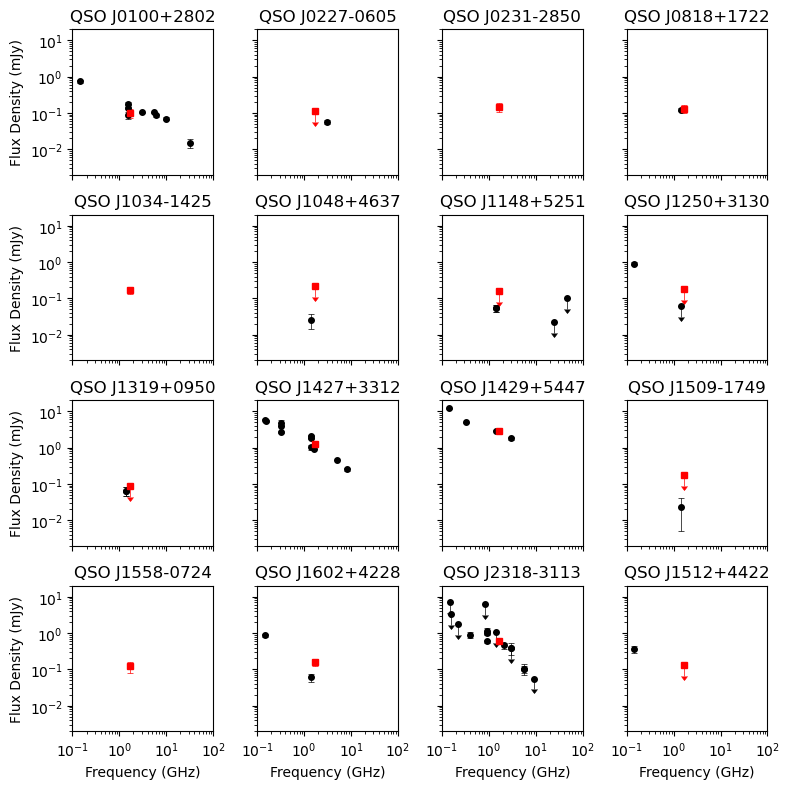

In [7]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))

i = 0

for qso in query_dict:
    for item in query_dict[qso]:
        freq, fluxd, fluxerr, uplims = query_dict[qso][item]
        #print(item, freq, fluxd, fluxerr, uplims)

        if item == "this work":
            c="r"
            fmt="s"
        else:
            c="k"
            fmt="o"

        ax[i//4, i%4].errorbar(freq, fluxd, yerr=fluxerr, label=item, uplims=uplims, fmt=fmt, capsize=2, capthick=.5, elinewidth=.5, ms=4, color=c)
        ax[i//4, i%4].set_title(qso.replace("_", " "))
        #ax[i//4, i%4].legend()
        ax[i//4, i%4].minorticks_on()
        ax[i//4, i%4].set_xscale("log")
        ax[i//4, i%4].set_yscale("log")
        ax[i//4, i%4].set_xlim([0.1, 100])
        ax[i//4, i%4].set_ylim([0.002, 20])

        if i//4 == 3:
            ax[i//4, i%4].set_xlabel("Frequency (GHz)")
        if i%4 == 0:
            ax[i//4, i%4].set_ylabel(r"Flux Density (mJy)")

    if len(query_dict[qso]) or qso in det_names:
        i += 1

ax[3, 0].set_xlabel("Frequency (GHz)")

plt.tight_layout()
plt.show()